<a href="https://colab.research.google.com/github/vedantdalvi7/Robustness-Evaluation-of-Neural-Network-based-image-processing-models/blob/main/Yolo_v5_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/dataset

/content/gdrive/MyDrive/dataset


In [4]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [5]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.5 MB/s eta 0:00:00


In [6]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [7]:
%cd /content/gdrive/MyDrive/dataset/Road_Sign_Dataset

/content/gdrive/MyDrive/dataset/Road_Sign_Dataset


In [18]:
# Assuming you're in the data folder
!cat annotations/road4.xml


<annotation>
    <folder>images</folder>
    <filename>road4.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>20</xmin>
            <ymin>109</ymin>
            <xmax>81</xmax>
            <ymax>237</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>162</ymin>
            <xmax>163</xmax>
            <ymax>272</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

In [19]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [20]:
print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [21]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [22]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:17<00:00, 50.18it/s] 


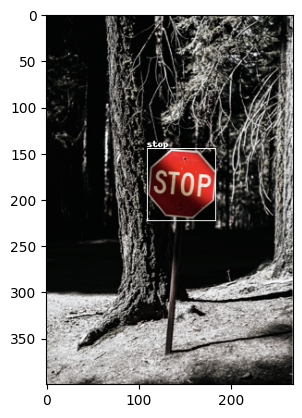

In [23]:
#Test the annotations

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

# Partitioning the dataset

In [24]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [25]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [26]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [27]:
!mv annotations labels

In [28]:
!cd /content/gdrive/MyDrive/dataset/yolov5

# Training the Detector for 100 epochs at batch size of 32

In [31]:
!python /content/gdrive/MyDrive/dataset/yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=road_sign_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=../yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.0

# Inference

In [34]:
!python /content/gdrive/MyDrive/dataset/yolov5/detect.py --source ../Road_Sign_Dataset/images/test/ --weights /content/gdrive/MyDrive/dataset/yolov5/runs/train/yolo_road_det2/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['/content/gdrive/MyDrive/dataset/yolov5/runs/train/yolo_road_det2/weights/best.pt'], source=../Road_Sign_Dataset/images/test/, data=../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../yolov5/runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/88 /content/gdrive/MyDrive/dataset/Road_Sign_Dataset/images/test/road100.png: 640x640 1 speedlimit, 11.6ms
image 2/88 /content/gdrive/MyDrive/dataset/Road_Sign_Dataset/images/test/road113.png: 448x640 1 speedlimit, 59.5ms
image 3/88 /content/g

# Randomly plotting one of the Detections

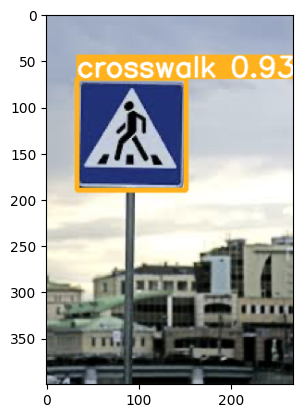

In [37]:
detections_dir = "/content/gdrive/MyDrive/dataset/yolov5/runs/detect/yolo_road_det3"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [42]:
!python /content/gdrive/MyDrive/dataset/yolov5/test.py --weights /content/gdrive/MyDrive/dataset/yolov5/runs/train/yolo_road_det2/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

Traceback (most recent call last):
  File "/content/gdrive/MyDrive/dataset/yolov5/test.py", line 7, in <module>
    from utils.datasets import *
ModuleNotFoundError: No module named 'utils.datasets'


In [ ]:
!pip uninstall utils